In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Basic stats

In [4]:
# Analysis by Sangjin here: https://github.com/regevs/sperm/issues/54#issuecomment-2587179795

In [5]:
flow_cell_stats_df = (
    pl.read_csv(
        "/lustre/scratch122/tol/projects/sperm/analysis/sequence_throughput/sequence_throughput_per_movie.csv"
    )
    .with_columns(
        sample_id = pl.col("Sample"),
        coverage = pl.col("Coverage").cast(pl.Float64),
        count = pl.col("Read count").cast(pl.Int64),
        mean = pl.col("Mean length (bp)").str.split(by=' ± ').list.first().cast(pl.Float64),
        std = pl.col("Mean length (bp)").str.split(by=' ± ').list.last().cast(pl.Float64),
    )
)


## Filter for only the used samples

In [6]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

CEPH_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')


In [7]:
unique_ids = pl.concat([
    rahbari_df["flow_cell"],
    sudmant_df["flow_cell"],
    CEPH_df["flow_cell"],
    flow_cell_stats_df.filter(pl.col("Sample").is_in(["PD47269d", "PD48473b"]))["Movie"],   # Campbell blood samples
]).unique()

In [8]:
stats_df = (flow_cell_stats_df.filter(pl.col("Movie").is_in(unique_ids)))

In [9]:
ceph_sample_ids_no_gps = sorted([x for x in CEPH_df["sample_id"].unique().to_list() if x not in ["NA12889", "NA12890", "NA12891", "NA12892"]])

In [10]:
len(ceph_sample_ids_no_gps)


12

## Read coverage

In [11]:
coverage_per_sample = stats_df.group_by("sample_id").agg(pl.col("coverage").sum())

In [13]:
print("Average coverage:", coverage_per_sample["coverage"].mean())

Average coverage: 57.687878787878795


In [14]:
print("Range coverage:", coverage_per_sample["coverage"].min(), coverage_per_sample["coverage"].max())

Range coverage: 17.25 159.14000000000001


## Get read counts

In [15]:
print("Total number of reads (before any processing):", stats_df["count"].sum())

Total number of reads (before any processing): 403873298


In [16]:
print("Total number of reads (before any processing), Rahbari sperm:", stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids))["count"].sum())

Total number of reads (before any processing), Rahbari sperm: 219381164


In [17]:
print("Total number of reads (before any processing), Sudmant sperm:", stats_df.filter(pl.col("sample_id").is_in(sudmant_sample_ids))["count"].sum())
      

Total number of reads (before any processing), Sudmant sperm: 48080396


In [18]:
print("Total number of reads (before any processing), total sperm:", 
    stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))["count"].sum()
)

Total number of reads (before any processing), total sperm: 267461560


In [19]:
print("Total number of reads (before any processing), Campbell blood:", 
    stats_df.filter(pl.col("sample_id").is_in(["PD47269d", "PD48473b"]))["count"].sum()
)

Total number of reads (before any processing), Campbell blood: 17609178


In [18]:
print("Total number of reads (before any processing), CEPH blood:", 
    stats_df.filter(pl.col("sample_id").is_in(ceph_sample_ids_no_gps))["count"].sum()
)

Total number of reads (before any processing), CEPH blood: 94043625


In [80]:
sperm_stats_df = stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))

print("Average read length, sperm:", (sperm_stats_df["mean"] * sperm_stats_df["count"]).sum() / sperm_stats_df["count"].sum())

Average read length, sperm: 13160.820895532914


In [19]:
ceph_stats_df = stats_df.filter(pl.col("sample_id").is_in(ceph_sample_ids_no_gps))

print("Average read length, sperm:", (ceph_stats_df["mean"] * ceph_stats_df["count"]).sum() / ceph_stats_df["count"].sum())

Average read length, sperm: 14479.788050218396


## Per sample stats

In [104]:
for ids in rahbari_sample_ids, sudmant_sample_ids, ceph_sample_ids:
    df = (
        (stats_df
            .filter(pl.col("sample_id").is_in(ids))
            .group_by("sample_id")
            .agg(
                n_reads = pl.col("count").sum(),
                mean_read_length = ((pl.col("mean") * pl.col("count")).sum() / pl.col("count").sum()),
                std_read_length = ((pl.col("std") * pl.col("count")).sum() / pl.col("count").sum()),
            )
        )
        .join(
            pl.DataFrame(
                {
                    "sample_id": sample_presentation_order, 
                    "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
                }
            ),
            on="sample_id",
            how="left",
        )
        .join(
            coverage_per_sample,
            on="sample_id",
            how="left",
        )
        .join(
            (stats_df
                .pivot(
                    values=["Instrument"],
                    index=["sample_id"],
                    on=["Instrument"],
                    aggregate_function='len'
                ) 
                .fill_null(0)
            ),
            on="sample_id",
            how="left",
        )
        .sort("paper_label_id", "sample_id")
        .select(
            "paper_label_id",
            "sample_id",
            "n_reads",
            pl.format("{} ± {}", pl.col("mean_read_length").cast(int), pl.col("std_read_length").cast(int)).alias("read_length"),
            "coverage",
        )
    )
    with pl.Config(thousands_separator=",", float_precision=2, tbl_rows=40):
        display(df)

paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
"""AA1-s1""","""PD50508b""","14,366,105","""12647 ± 4536""",60.58
"""AA1-s2""","""PD50508f""","3,040,994","""17011 ± 3308""",17.25
"""AA2-t1""","""PD46180c""","29,375,470","""13929 ± 5568""",136.38
"""AA2-t2""","""PD50519d""","33,329,411","""12047 ± 5315""",133.84
"""AA3""","""PD50477f""","38,422,720","""11232 ± 4354""",143.85
"""AA4""","""PD50489e""","25,190,427","""10548 ± 5358""",88.58
"""AD""","""PD50523b""","35,591,943","""13413 ± 4821""",159.14
"""AN-s1""","""PD50521b""","11,618,202","""14522 ± 4111""",56.24
"""AN-s2""","""PD50521e""","28,445,892","""10863 ± 4401""",103.02


paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
"""AA5""","""1894""","9,181,559","""17527 ± 4909""",53.65
"""AA6""","""3898""","8,634,738","""17985 ± 4982""",51.76
"""AA7""","""7899""","5,367,893","""16846 ± 4671""",30.14
"""AA8""","""95619""","8,876,456","""16835 ± 5001""",49.82
"""AA9""","""115980""","9,037,595","""16197 ± 4788""",48.80
"""AB""","""2895""","6,982,155","""17318 ± 4406""",40.31


paper_label_id,sample_id,n_reads,read_length,coverage
str,str,i64,str,f64
null,"""200100""","6,619,579","""12059 ± 4021""",26.61
null,"""200101""","9,188,613","""10183 ± 4541""",31.20
null,"""200102""","9,387,139","""12443 ± 5279""",38.94
null,"""200104""","5,045,933","""12890 ± 5513""",21.68
null,"""200106""","4,635,172","""13215 ± 4344""",20.42
null,"""NA12877""","11,128,682","""17804 ± 3246""",66.04
null,"""NA12878""","11,480,931","""16119 ± 3558""",61.69
null,"""NA12879""","4,933,624","""17756 ± 4595""",29.21
null,"""NA12881""","5,187,297","""22961 ± 4870""",39.71


# Get read counts after filtering

In [3]:
%%time
reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

NameError: name 'pl' is not defined

In [106]:
%%time
(reads_df
    .filter(pl.col("is_high_quality_read")  )
    .select(pl.len())
).collect()

CPU times: user 5.47 s, sys: 3.36 s, total: 8.84 s
Wall time: 14.2 s


len
u32
196296004


In [107]:
%%time
ceph_reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] 
)

16it [00:00, 2304.17it/s]

CPU times: user 12.1 ms, sys: 5.22 ms, total: 17.4 ms
Wall time: 10.2 ms


In [108]:
%%time
(ceph_reads_df
    .filter(pl.col("is_high_quality_read"))
    .select(pl.len())
).collect()

CPU times: user 2.71 s, sys: 725 ms, total: 3.43 s
Wall time: 12.1 s


len
u32
88206531


# Number of SNPs

In [6]:
%%time
all_snps = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ]
)


56it [00:00, 1369.93it/s]
12it [00:00, 1560.77it/s]

CPU times: user 47.7 ms, sys: 11.7 ms, total: 59.4 ms
Wall time: 58.2 ms


In [110]:
%%time
all_snps.select(pl.len()).collect()

CPU times: user 4.12 s, sys: 2.26 s, total: 6.39 s
Wall time: 1min 18s


len
u32
3021086931


In [111]:
%%time
all_snps.select("read_name", "start", "is_high_quality_snp").collect().filter("is_high_quality_snp").select(pl.len())

CPU times: user 2min 16s, sys: 2min 11s, total: 4min 27s
Wall time: 2min 17s


len
u32
1163633539


In [24]:
%%time
all_ceph_snps = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        )
        for sample_id, sample_set, flow_cell in tqdm.tqdm(CEPH_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
        if sample_id in ceph_sample_ids_no_gps
    ] 
)


52it [00:00, 3974.92it/s]

CPU times: user 18.3 ms, sys: 1.08 ms, total: 19.4 ms
Wall time: 17.8 ms


In [113]:
%%time
all_ceph_snps.select(pl.len()).collect()

CPU times: user 2.4 s, sys: 1.62 s, total: 4.02 s
Wall time: 16.8 s


len
u32
1700583106


In [25]:
%%time
(all_ceph_snps
    .select("read_name", "start", "is_high_quality_snp")
    .collect()
    .filter("is_high_quality_snp")
    .select(pl.len())
)

CPU times: user 31.6 s, sys: 1min 6s, total: 1min 38s
Wall time: 1min 9s


len
u32
389685716


## High quality SNPs per read

In [115]:
rows = []

for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))
        
for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))        

56it [06:44,  7.23s/it]
12it [01:32,  7.68s/it]


In [122]:
total_hist = {s:np.zeros(400) for s in sample_ids + ["All"]}
for row in rows:
    for n_snps, cnt in row[-1].rows():
        total_hist[str(row[0])][n_snps] += cnt
        total_hist["All"][n_snps] += cnt

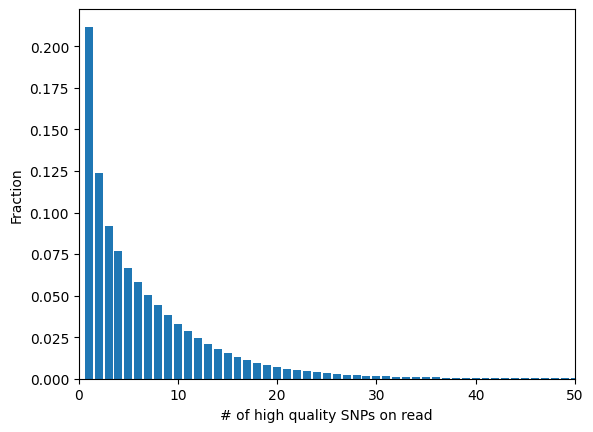

In [123]:
plt.bar(x=np.arange(400), height=total_hist["All"] / total_hist["All"].sum())
plt.xlim(0, 50)
plt.xlabel("# of high quality SNPs on read");
plt.ylabel("Fraction");

In [124]:
for k,T in total_hist.items():
    print(k, np.sum([i*h for i, h in enumerate(T)]) / np.sum(T))

PD50477f 5.759972152944968
PD50519d 5.909671306833053
PD50508f 8.121031856311262
PD50523b 6.292058776310657
PD50521b 6.288746222095818
PD50508b 6.791652024049477
PD46180c 6.169597220184443
PD50521e 5.157612829351835
PD50489e 5.638578126174709
1894 9.209768567361532
3898 9.94499472871258
7899 9.288745167615568
95619 9.050880538177411
115980 9.337350353758193
2895 9.651255895471687
All 6.699282020135253


# Candidate read classes

In [12]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [13]:
sudmant_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')

In [14]:
ceph_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')

In [25]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

9it [00:00, 802.07it/s]


CPU times: user 66.4 ms, sys: 201 ms, total: 267 ms
Wall time: 8.86 s


len
u32
50653


In [26]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

6it [00:00, 1517.93it/s]


CPU times: user 37.9 ms, sys: 133 ms, total: 171 ms
Wall time: 6.76 s


len
u32
14793


In [137]:
50653+14793

65446

In [125]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

16it [00:00, 3612.86it/s]


CPU times: user 158 ms, sys: 246 ms, total: 404 ms
Wall time: 4.22 s


len
u32
22750


In [93]:
# %%time
# (
#     pl.concat([
#         pl.scan_parquet(
#             f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
#         ) 
#         for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
#         for chrom in aut_chrom_names
#     ]).select("class", "sample_id").collect()
#         .pivot(
#             values=["class"],
#             index=["sample_id"],
#             on=["class"],
#             aggregate_function='len'
#         )
#         .sort(by="sample_id")
#         .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
# )

In [15]:
%%time
rahbari_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]

9it [00:00, 26033.61it/s]

CPU times: user 8.5 ms, sys: 107 μs, total: 8.6 ms
Wall time: 4.05 ms


In [16]:
%%time
sudmant_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]

6it [00:00, 42438.15it/s]

CPU times: user 2.45 ms, sys: 4.37 ms, total: 6.81 ms
Wall time: 3.48 ms


In [17]:
%%time
ceph_reads_filenames = [
    (
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
    if sample_id in ceph_sample_ids_no_gps
]

16it [00:00, 87381.33it/s]

CPU times: user 5.08 ms, sys: 823 μs, total: 5.9 ms
Wall time: 2.26 ms


In [18]:
all_filenames = rahbari_reads_filenames + sudmant_reads_filenames + ceph_reads_filenames

In [19]:
#reads_df = pl.concat([rahbari_reads_df, sudmant_reads_df, ceph_reads_df])

In [20]:
%%time
def F(filename):
    return (
        pl.scan_parquet(filename)
        .select(
            'read_name',
            'chrom',
            'sample_id',
            'is_high_quality_read',
            "high_quality_classification_class",
            "high_quality_classification_in_detectable_class",
            'grch37_reference_start',
            'grch38_reference_start',
            'T2T_reference_start',
            "mid_quality_snp_positions",
            "mid_quality_snp_positions_alleles",
            "total_mismatches",
            "is_contamination",
            "read_length",
            "full_read_crossover_prob",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            "idx_transitions",
            "snp_positions_on_read",
        )
        .filter("is_high_quality_read")
        .filter(~pl.col("is_contamination"))
        .filter(pl.col("high_quality_classification_class").is_not_null())
        .collect(streaming=True)
    )

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in all_filenames
)
#dfs = [F(filename) for filename in tqdm.tqdm(all_filenames)]

candidates_df = pl.concat(dfs)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

CPU times: user 1.43 s, sys: 595 ms, total: 2.03 s
Wall time: 45.4 s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:   45.4s finished


In [21]:
len(candidates_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids+sudmant_sample_ids)))

17329

In [20]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        on=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
    .sort(by="sample_id")
)

for ids in rahbari_sample_ids+sudmant_sample_ids, ceph_sample_ids_no_gps:
    df = (call_stats_df
        .filter(pl.col("sample_id").is_in(ids))
        .join(
            pl.DataFrame(
                {
                    "sample_id": sample_presentation_order, 
                    "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
                }
            ),
            on="sample_id",
            how="left",
        )
        .join(
            coverage_per_sample,
            on="sample_id",
            how="left",
        )
        .join(
            (stats_df
                .pivot(
                    values=["Instrument"],
                    index=["sample_id"],
                    on=["Instrument"],
                    aggregate_function='len'
                ) 
                .fill_null(0)
            ),
            on="sample_id",
            how="left",
        )
        .sort("paper_label_id", "sample_id")
        .select("paper_label_id", "sample_id", "coverage", "CO", "GC", "ambiguous", "CNCO", "Sequel_IIe", "Revio")
    )
    with pl.Config(tbl_rows=40, float_precision=1):
        display(df)
        display(df.sum())



paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
"""AA1-s1""","""PD50508b""",60.6,395,105,371,6,2,2
"""AA1-s2""","""PD50508f""",17.2,114,27,94,5,2,0
"""AA2-t1""","""PD46180c""",136.4,740,208,756,26,3,4
"""AA2-t2""","""PD50519d""",133.8,688,167,909,14,3,4
"""AA3""","""PD50477f""",143.8,714,191,1174,10,3,4
"""AA4""","""PD50489e""",88.6,499,137,522,18,4,3
"""AA5""","""1894""",53.6,433,159,341,5,0,2
"""AA6""","""3898""",51.8,380,161,293,5,0,2
"""AA7""","""7899""",30.1,427,151,334,6,0,1


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,null,1173.4,7143,2382,7585,219,29,37


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,"""200100""",26.6,null,11,20,null,0,1
null,"""200101""",31.2,1,23,17,null,0,2
null,"""200102""",38.9,null,23,19,null,0,2
null,"""200104""",21.7,null,7,1,null,0,1
null,"""200106""",20.4,null,3,2,null,0,1
null,"""NA12877""",66.0,null,52,12,null,9,0
null,"""NA12878""",61.7,3,53,7,1,8,0
null,"""NA12879""",29.2,null,33,9,1,5,1
null,"""NA12881""",39.7,5,67,18,2,0,4


paper_label_id,sample_id,coverage,CO,GC,ambiguous,CNCO,Sequel_IIe,Revio
str,str,f64,u32,u32,u32,u32,u32,u32
null,null,453.9,11,369,143,9,22,18


In [38]:
(11/453.0) / (7143/1173.4) * 100

0.39889621633615896

In [39]:
(369/453.0) / (2382/1173.4) * 100

40.12661184045908

In [40]:
(143/453.0) / (7585/1173.4) * 100

4.883467864569464

In [41]:
(9/453.0) / (219/1173.4) * 100

10.645014968701807

In [21]:
ceph_id_to_age = {
    '200100': 58,
    '200101': 37,
    '200102': 35,
    '200104': 29,
    '200106': 24,
    'NA12877': 74,
    'NA12878': 73,
    'NA12879': 53,
    'NA12881': 50,
    'NA12882': 47,
    'NA12885': 46,
    'NA12886': 41,
    # 'NA12889': 80,
    # 'NA12890': 76,
    # 'NA12891': 83,
    # 'NA12892': 82
}

In [22]:
xdf = (call_stats_df
    .join(
        pl.DataFrame({
            "sample_id": list(ceph_id_to_age.keys()),
            "sample_age": list(ceph_id_to_age.values()),
        }),
        on="sample_id",
    )
    .join(
        coverage_per_sample,
        on="sample_id",
        how="left",
    )
    .fill_null(0)
    .with_columns(
        NCO_rate = pl.col("GC") / pl.col("coverage"),
        total_rate = (pl.col("GC") + pl.col("CO") + pl.col("ambiguous") + pl.col("CNCO")) / pl.col("coverage"),
    )
)

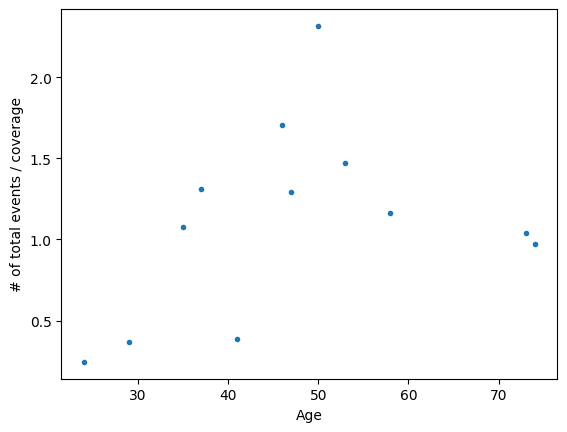

In [23]:
plt.plot(
    xdf["sample_age"],
    xdf["total_rate"],
    '.',
);
plt.xlabel("Age");
plt.ylabel("# of total events / coverage");

In [29]:
import scipy.special

log_factorial = lambda n: scipy.special.gammaln(n+1)

In [37]:
# No age

scipy.optimize.minimize_scalar(
    fun = lambda L: -(
        -(L * xdf["coverage"]).sum() 
        + (xdf["GC"] * (np.log(L * xdf["coverage"]))).sum()
        - log_factorial(xdf["GC"]).sum()        
    ),
    bounds = (0,10000),
)

 message: Solution found.
 success: True
  status: 0
     fun: 73.76331124080411
       x: 0.8128994252536008
     nit: 27
    nfev: 27

In [38]:
# With age

scipy.optimize.minimize_scalar(
    fun = lambda L: -(
        -(L * xdf["coverage"] * xdf["sample_age"]).sum() 
        + (xdf["GC"] * (np.log(L * xdf["coverage"] * xdf["sample_age"]))).sum()
        - log_factorial(xdf["GC"]).sum()        
    ),
    bounds = (0,10000),
)

 message: Solution found.
 success: True
  status: 0
     fun: 70.9384474054309
       x: 0.015742107765931813
     nit: 36
    nfev: 36

In [41]:
73.763-70.93844

2.8245600000000053

In [39]:
np.exp(73.763-70.93844)

np.float64(16.853527802195362)

In [40]:
0.812899/0.015

54.19326666666667

In [60]:
scipy.stats.linregress(x = xdf["sample_age"], y = xdf["GC"])

LinregressResult(slope=np.float64(0.892206711657576), intercept=np.float64(-11.406767125820465), rvalue=np.float64(0.6541752668572608), pvalue=np.float64(0.021008215006468826), stderr=np.float64(0.3262046536509503), intercept_stderr=np.float64(16.172372265930374))

In [42]:
scipy.stats.linregress(x = xdf["sample_age"] * xdf["coverage"], y = xdf["GC"])

LinregressResult(slope=np.float64(0.010895976101628926), intercept=np.float64(9.466000042639916), rvalue=np.float64(0.7008950444473067), pvalue=np.float64(0.011109043378058526), stderr=np.float64(0.003506418223608965), intercept_stderr=np.float64(8.260745342808423))

In [51]:
linreses = [scipy.stats.linregress(x = np.random.permutation(xdf["sample_age"] * xdf["coverage"]), y = xdf["GC"]) for i in tqdm.trange(100)]

100%|██████████| 100/100 [00:00<00:00, 832.26it/s]


In [54]:
(np.array([x.slope for x in linreses]) < 0.011).mean()

np.float64(1.0)

### Make a dataframe of positions of all converted SNPs

In [22]:
NCO_df = candidates_df.filter(pl.col("high_quality_classification_class") == "GC")

In [23]:
%%time
converted_snps_df = (NCO_df
    .with_columns(
        (pl.col("idx_transitions").list.get(0)+1).alias("A"),
        (pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("B"),
    )
    .select(
        "sample_id",
        "chrom",
        "read_name",
        pl.col("snp_positions_on_read").list.slice(pl.col("A"), pl.col("B")).alias("start"),
        pl.col("AA_heat").is_not_null().alias("has_AA_DSB"),
    )
    .explode("start")
)

CPU times: user 72.9 ms, sys: 12.8 ms, total: 85.7 ms
Wall time: 31 ms


### Cross it with the sequences

In [24]:
filenames = []
for R in rahbari_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in sudmant_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )

for R in ceph_df.to_pandas().itertuples():
    for chrom in aut_chrom_names:  
        filenames.append(        
            str(Path("/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis")
                / f"{R.sample_set}/{R.sample_id}/{R.flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet")
        )
        
        
def F(filename):
    high_conf_snps_df = pl.scan_parquet(filename)
    
    df = (converted_snps_df
            .lazy()
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
            )
        ).collect()
    
    return df

dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(filename) for filename in filenames
)
        
all_converted_snps_with_seq_df = pl.concat(dfs)

converted_snps_with_seq_df = all_converted_snps_with_seq_df.filter(
    (pl.col("refseq_start1").is_in(["G", "C"]) & pl.col("refseq_start2").is_in(["A", "T"])) |
    (pl.col("refseq_start2").is_in(["G", "C"]) & pl.col("refseq_start1").is_in(["A", "T"]))
)
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed:  2.0min finished


In [25]:
read_to_converted_alleles_df = (all_converted_snps_with_seq_df
    .with_columns(
        original_allele = pl.when(pl.col("fits1_more") == 1).then("refseq_start2").otherwise("refseq_start1"),
        converted_allele = pl.when(pl.col("fits1_more") == 0).then("refseq_start2").otherwise("refseq_start1"),
    )
    .sort("read_name", "start")
    .group_by("read_name", maintain_order=True)
    .agg(    
        "original_allele", "converted_allele",
    ) 
)

# Save to xls file

In [31]:
(candidates_df
    .rename({
        "high_quality_classification_class": "event_type",
        "mid_quality_snp_positions": "snp_positions",
        "mid_quality_snp_positions_alleles": "snp_alleles",
    })
    .join(
        pl.DataFrame({
            "sample_id": sample_id_to_paper_label.keys(),
            "label": sample_id_to_paper_label.values(),
        }),
        on="sample_id",
    )
    .join(
        read_to_converted_alleles_df,
        on="read_name",
        how="left",
    )
    .with_columns(
        dataset = (
            pl.when(pl.col("sample_id").is_in(rahbari_sample_ids))
            .then(pl.lit("TwinsUK"))
            .otherwise(
                pl.when(pl.col("sample_id").is_in(sudmant_sample_ids))
                .then(pl.lit("SL"))
                .otherwise(pl.lit("Platinum"))
            )
        ).cast(pl.Enum(["TwinsUK", "SL", "Platinum"])),
        chrom = pl.col("chrom").cast(pl.Enum(aut_chrom_names)),
        event_type = pl.col("event_type").replace(["GC", "CNCO"], ["NCO", "complex"]),
        genetic_length_in_cm = pl.col("full_read_crossover_prob") * 1e2,
        genetic_length_in_bp = pl.col("read_length"),
        gc_tract_lower_bound = (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True)+1)
        ),
        gc_tract_upper_bound = (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True))
        ),
        n_snps_converted = pl.col("idx_transitions").list.diff(null_behavior="drop").list.first(),     
    )
    .with_columns(
        (pl.col("genetic_length_in_cm")/(pl.col("genetic_length_in_bp")*1e-6)).alias("read_recomb_rate_in_cm_bp"),
    ) 
    .rename(
        {
            'AA_motif_center_pos': 'DSB_PRDM9_motif_center_pos',
            'AA_heat': 'DSB_PRDM9_heat',
            'AA_motif_strand': 'DSB_PRDM9_motif_strand',
        }
    )
    .sort(["dataset","label", "event_type", "chrom"])
    [[
        "dataset",
        "label", 
        "event_type",
        "chrom",
        "read_length",
        "genetic_length_in_cm",
        "read_recomb_rate_in_cm_bp",
        "n_snps_converted",
        "gc_tract_lower_bound",
        "gc_tract_upper_bound",
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "snp_positions",
        "snp_alleles",
        "original_allele", 
        "converted_allele",
        'DSB_PRDM9_motif_center_pos',
        'DSB_PRDM9_heat',
        'DSB_PRDM9_motif_strand',
    ]]
    #.write_excel("/nfs/users/nfs_r/rs42/rs42/git/sperm/recombination_events.xlsx")
    #.write_parquet("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250325.parquet")
    #.write_excel("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250417.xlsx")
    .write_parquet("/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250417.parquet")
)

In [44]:
call_stats_df = (candidates_df
    .with_columns(
        combined_class = pl.when(
            pl.col("high_quality_classification_class") == "CNCO"
        ).then(
            pl.lit("Complex")
        ).when(
            pl.col("high_quality_classification_in_detectable_class").is_not_null()
        ).then(
            "high_quality_classification_in_detectable_class"
        ).otherwise(
            pl.lit("Ambiguous")
        )
    )
    .pivot(
        values=["combined_class"],
        index=["sample_id"],
        columns=["combined_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "NCO", "Ambiguous", "Complex")
)

# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )
with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,NCO,Ambiguous,Complex
str,u32,u32,u32,u32
"""PD47269d""",14,15,81,22
"""PD48473b""",6,15,47,3
